In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,  mean_absolute_percentage_error


In [2]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df['LogPassengers'] = np.log(df['Passengers'])

In [4]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [5]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [9]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value
 
series = df['DiffLogPassengers'].to_numpy()[1:]

T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [10]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [14]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.6837135048453112

In [15]:
lr.score(Xtest, Ytest)

0.6492870172668163

In [16]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False  # first T+1 values are not predicable

In [17]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [18]:
#Last known train value
last_train = train.iloc[-1]['LogPassengers']

In [19]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

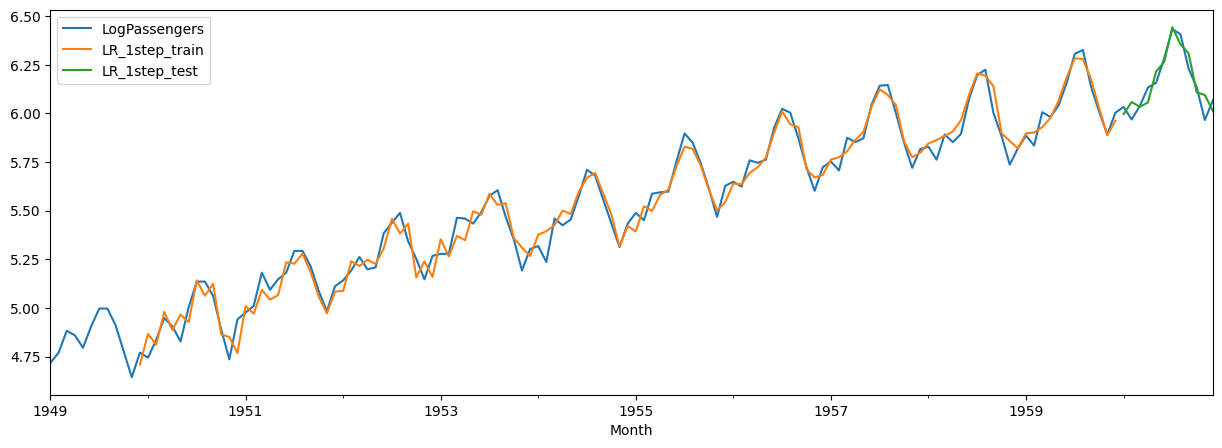

In [20]:
# plot 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

In [21]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0] # 1x1 array -> scalar
    multistep_predictions.append(p)  # update the predictions list
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [23]:
# save multi-step forecast to df
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

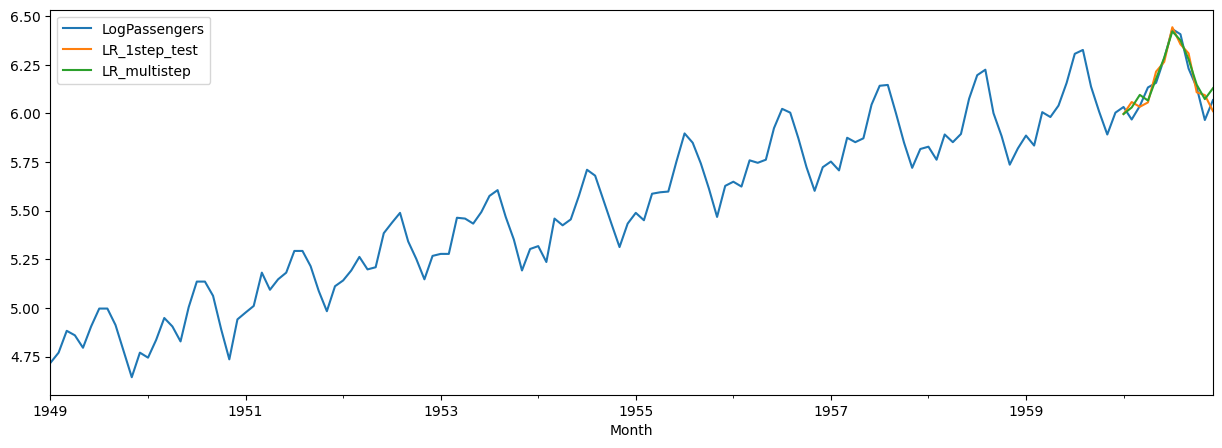

In [24]:
# plot 1-step and multi-step forecasts
df[['LogPassengers', 'LR_1step_test', 'LR_multistep']].plot(figsize=(15, 5));

In [25]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (122, 10) Y.shape (122, 12)


In [26]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [27]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8141637147930573

In [29]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.7690077978619658

In [30]:
# save multi-output forecast to df
df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(Xtest_m).flatten())

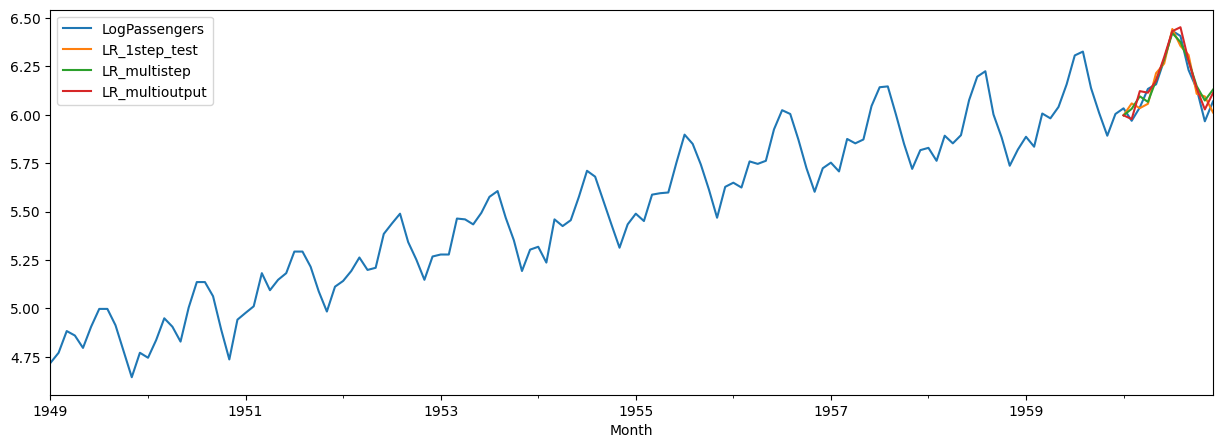

In [31]:
# plot all forecasts
cols = ['LogPassengers', 'LR_1step_test', 'LR_multistep', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [33]:
# MAPE

test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx]['LR_multistep'])
print("multi-step MAPE: ", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx]['LR_multioutput'])
print("multi-output MAPE: ", mape2)

multi-step MAPE:  0.007109281288502572
multi-output MAPE:  0.005245261617574867
